# Handout 08
#### Sara Díaz del Ser


In [294]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import pandas as pd
from termcolor import colored
import itertools as it
import numpy as np
from collections import Counter
import diazdelser_fastatools as fa
import random

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")



plt.style.use('dark_background')

In [3]:
# Files
insensitive_file = './data/exosome-insensitive.fa'
sensitive_file= './data/exosome-sensitive.fa'

### Ex. 1 _(20 pts)_ K-Mer Distributions

#### (a) _(5 pts)_ Write a function ```kmer_frequencies(seqs,k)```
that takes a set of $m$ RNA sequences seqs and a parameter k as input and returns the relative frequencies for all
k-mers contained in the sequences as a dictionary. Note, that each sequence of length $n$ contains $n$ - $k$ + 1 k-mers.

For the calculation of relative frequencies use pseudocounts. That is, the frequency of
each k-mer is increased by 1, regardless whether it occurs in the sequences or not.

In [243]:
def kmer_frequencies(seq:str,k:int) -> dict:
	"""Takes a sequence and a parameter k and returns the relative frequencies for all k-mers"""
	# Generate dict of possible kmers
	kmers = { "".join(kmer) : 1 for kmer in it.product(['A','G','T','C'], repeat=k) }

	# Count each kmer
	for i in range(0,len(seq)-k+1):
		kmers[seq[i:i+k]] = kmers.get(seq[i:i+k], 1) + 1

	# Observed relative freq
	return { key: val/sum(kmers.values()) for key, val in kmers.items()}


def kmer_freq_wrapper(seqs:list, k:int) -> dict:
	"""Takes a set of RNA sequences and a parameter k and returns the relative frequencies for all k-mers"""
	return { seq : kmer_frequencies(seq,k) for seq in seqs }

In [71]:
# Example
kmer_freq_wrapper(['GATGCGTAATGGATTCGATGCATGCGGCGTGAACTAGTCTAACG'],2)

{'GATGCGTAATGGATTCGATGCATGCGGCGTGAACTAGTCTAACG': {'AA': 0.07,
  'AG': 0.03,
  'AT': 0.1,
  'AC': 0.05,
  'GA': 0.08,
  'GG': 0.05,
  'GT': 0.07,
  'GC': 0.08,
  'TA': 0.07,
  'TG': 0.1,
  'TT': 0.03,
  'TC': 0.05,
  'CA': 0.03,
  'CG': 0.1,
  'CT': 0.05,
  'CC': 0.02}}

#### (b) _(6 pts)_
To determine whether a certain k-mer is over- or under-represented one needs
to determine the background frequencies of individual nucleotides. If you solved the
previous exercise properly, the background frequencies for a set of sequences seqs can
be obtained form the call ```kmer_frequencies(seqs,1)```.

Similar to the calculations of the BLOSUM scoring matrix odds-ratios can be calculated
for the k-mers.

In [145]:
def expected_relative_frequency(seq:str, kmers:dict) -> dict:
	"""Takes a sequence and returns the expected relative frequency for all k-mers"""
	# Observed relative freq of each nucleotide
	observed = { key : val/sum(Counter(seq).values()) for key,val in Counter(seq).items() }
	return { kmer : np.product([ observed[nt] for nt in kmer ]) for kmer in kmers.keys() }

In [101]:
# Example
seq = 'GATGCGTAATGGATTCGATGCATGCGGCGTGAACTAGTCTAACG'
kmers = kmer_frequencies(seq,2)
expected_relative_frequency(seq, kmers)

{'AA': 0.0625,
 'AG': 0.08,
 'AT': 0.0625,
 'AC': 0.045,
 'GA': 0.08,
 'GG': 0.1024,
 'GT': 0.08,
 'GC': 0.0576,
 'TA': 0.0625,
 'TG': 0.08,
 'TT': 0.0625,
 'TC': 0.045,
 'CA': 0.045,
 'CG': 0.0576,
 'CT': 0.045,
 'CC': 0.0324}

Write a function ```log_odds_ratio(observed,background)``` that takes as argument a
dictionary of observed frequencies of k-mers and a dictionary containing the background
frequencies of the individual nucleotides and calculates the log-odds ratio.

In [94]:
def log_odds_ratio(observed:dict, background:dict) -> dict:
	"""Takes a sequence and returns the log_odd_ratio for all k-mers"""
	return { key : np.log2(observed[key]/background[key]) for key in observed.keys() }

In [103]:
# Example
seq = 'GATGCGTAATGGATTCGATGCATGCGGCGTGAACTAGTCTAACG'
observed = kmer_frequencies(seq,2)
background = expected_relative_frequency(seq, observed)
log_odds_ratio(observed, background)

{'AA': 0.16349873228287956,
 'AG': -1.415037499278844,
 'AT': 0.6780719051126377,
 'AC': 0.15200309344505006,
 'GA': 0.0,
 'GG': -1.034215715337913,
 'GT': -0.19264507794239571,
 'GC': 0.4739311883324125,
 'TA': 0.16349873228287956,
 'TG': 0.32192809488736235,
 'TT': -1.0588936890535685,
 'TC': 0.15200309344505006,
 'CA': -0.5849625007211563,
 'CG': 0.7958592832197747,
 'CT': 0.15200309344505006,
 'CC': -0.6959938131098998}

In [80]:
def log_odds_wrapper(seqs:list, k:int) -> dict:
	"""Takes a set of RNA sequences and a parameter k and returns the log_odds_ratio for all k-mers"""
	results = {}
	for seq in seqs:
		observed = kmer_frequencies(seq,k)
		background = expected_relative_frequency(seq, kmers)
		results[seq] = log_odds_ratio(observed, background)

	return results

In [ ]:
# Example
log_odds_wrapper([seq],2)

#### (c) _(3 pts)_ For the given data exosome-sensitive.fa and exosome-insensitive.fa calculate:
Perform these calculations for k = 2; 3; and 4.

i. The background frequencies of the nucleotides using the combined set of sequences.

In [118]:
# In case it means all the sequences combined:
def background_from_all(list_of_files:list, k_list:list):
	"""Calculate expected relative frequencies in given files for given list of K"""

	results = {}
	all_sequences = []

	# Open all files and get lists of sequences
	for file in list_of_files:
		with open(file) as f:
			_ ,sequences  = zip(*fa.all_fasta_sequences(f))
			all_sequences.extend(sequences)

	# Combine sequences
	all_sequences = "".join(sequences)
	# Calculate freq for each k
	for k in k_list:
		observed = kmer_frequencies(all_sequences,k)
		background = expected_relative_frequency(all_sequences, observed)
		results[k] = background

	return results

In [120]:
results = background_from_all([sensitive_file, insensitive_file], [2,3,4])

In [121]:
# Print results
for key, val in results.items():
	print(f"K: {key}\n{val}")

K: 2
{'AA': 0.0361, 'AG': 0.0589, 'AT': 0.0399, 'AC': 0.053200000000000004, 'GA': 0.0589, 'GG': 0.0961, 'GT': 0.06509999999999999, 'GC': 0.0868, 'TA': 0.0399, 'TG': 0.06509999999999999, 'TT': 0.04409999999999999, 'TC': 0.058800000000000005, 'CA': 0.053200000000000004, 'CG': 0.0868, 'CT': 0.058800000000000005, 'CC': 0.07840000000000001}
K: 3
{'AAA': 0.0068590000000000005, 'AAG': 0.011191, 'AAT': 0.007581, 'AAC': 0.010108, 'AGA': 0.011191, 'AGG': 0.018259, 'AGT': 0.012369, 'AGC': 0.016492000000000003, 'ATA': 0.007581, 'ATG': 0.012369, 'ATT': 0.008379, 'ATC': 0.011172, 'ACA': 0.010108, 'ACG': 0.016492, 'ACT': 0.011172, 'ACC': 0.014896000000000003, 'GAA': 0.011191, 'GAG': 0.018259, 'GAT': 0.012369, 'GAC': 0.016492000000000003, 'GGA': 0.018259, 'GGG': 0.029791, 'GGT': 0.020181, 'GGC': 0.026908000000000005, 'GTA': 0.012368999999999998, 'GTG': 0.020180999999999998, 'GTT': 0.013670999999999997, 'GTC': 0.018227999999999998, 'GCA': 0.016492, 'GCG': 0.026908, 'GCT': 0.018228, 'GCC': 0.02430400000

ii. The observed frequencies of k-mers for a) the sensitive sequences and b) the insen-
sitive sequences


In [122]:
sensitive = background_from_all([sensitive_file], [2,3,4])
insensitive = background_from_all([insensitive_file], [2,3,4])

In [123]:
# Print results sensitive
for key, val in sensitive.items():
	print(f"K: {key}\n{val}")

K: 2
{'AA': 0.0576, 'AG': 0.0624, 'AT': 0.06, 'AC': 0.06, 'GA': 0.0624, 'GG': 0.06760000000000001, 'GT': 0.065, 'GC': 0.065, 'TA': 0.06, 'TG': 0.065, 'TT': 0.0625, 'TC': 0.0625, 'CA': 0.06, 'CG': 0.065, 'CT': 0.0625, 'CC': 0.0625}
K: 3
{'AAA': 0.013824, 'AAG': 0.014976, 'AAT': 0.0144, 'AAC': 0.0144, 'AGA': 0.014975999999999998, 'AGG': 0.016224, 'AGT': 0.0156, 'AGC': 0.0156, 'ATA': 0.0144, 'ATG': 0.0156, 'ATT': 0.015, 'ATC': 0.015, 'ACA': 0.0144, 'ACG': 0.0156, 'ACT': 0.015, 'ACC': 0.015, 'GAA': 0.014975999999999998, 'GAG': 0.016224, 'GAT': 0.0156, 'GAC': 0.0156, 'GGA': 0.016224000000000002, 'GGG': 0.017576, 'GGT': 0.016900000000000002, 'GGC': 0.016900000000000002, 'GTA': 0.0156, 'GTG': 0.016900000000000002, 'GTT': 0.01625, 'GTC': 0.01625, 'GCA': 0.0156, 'GCG': 0.016900000000000002, 'GCT': 0.01625, 'GCC': 0.01625, 'TAA': 0.0144, 'TAG': 0.0156, 'TAT': 0.015, 'TAC': 0.015, 'TGA': 0.0156, 'TGG': 0.016900000000000002, 'TGT': 0.01625, 'TGC': 0.01625, 'TTA': 0.015, 'TTG': 0.01625, 'TTT': 0.01

In [124]:
# Print results insensitive
for key, val in insensitive.items():
	print(f"K: {key}\n{val}")


K: 2
{'AA': 0.0361, 'AG': 0.0589, 'AT': 0.0399, 'AC': 0.053200000000000004, 'GA': 0.0589, 'GG': 0.0961, 'GT': 0.06509999999999999, 'GC': 0.0868, 'TA': 0.0399, 'TG': 0.06509999999999999, 'TT': 0.04409999999999999, 'TC': 0.058800000000000005, 'CA': 0.053200000000000004, 'CG': 0.0868, 'CT': 0.058800000000000005, 'CC': 0.07840000000000001}
K: 3
{'AAA': 0.0068590000000000005, 'AAG': 0.011191, 'AAT': 0.007581, 'AAC': 0.010108, 'AGA': 0.011191, 'AGG': 0.018259, 'AGT': 0.012369, 'AGC': 0.016492000000000003, 'ATA': 0.007581, 'ATG': 0.012369, 'ATT': 0.008379, 'ATC': 0.011172, 'ACA': 0.010108, 'ACG': 0.016492, 'ACT': 0.011172, 'ACC': 0.014896000000000003, 'GAA': 0.011191, 'GAG': 0.018259, 'GAT': 0.012369, 'GAC': 0.016492000000000003, 'GGA': 0.018259, 'GGG': 0.029791, 'GGT': 0.020181, 'GGC': 0.026908000000000005, 'GTA': 0.012368999999999998, 'GTG': 0.020180999999999998, 'GTT': 0.013670999999999997, 'GTC': 0.018227999999999998, 'GCA': 0.016492, 'GCG': 0.026908, 'GCT': 0.018228, 'GCC': 0.02430400000

iii. Using the common background frequency calculate the log-odds ratio for the set of
sensitive and insensitve sequences

In [125]:
# In case it means all the sequences combined:
def logs_odd_from_all(list_of_files:list, k_list:list):
	"""Calculate expected relative frequencies in given files for given list of K"""

	results = {}
	all_sequences = []

	# Open all files and get lists of sequences
	for file in list_of_files:
		with open(file) as f:
			_ ,sequences  = zip(*fa.all_fasta_sequences(f))
			all_sequences.extend(sequences)

	# Combine sequences
	all_sequences = "".join(sequences)
	# Calculate freq for each k
	for k in k_list:
		observed = kmer_frequencies(all_sequences,k)
		background = expected_relative_frequency(all_sequences, observed)
		results[k] = log_odds_ratio(observed, background)

	return results

In [126]:
results = logs_odd_from_all([sensitive_file, insensitive_file], [2,3,4])

/var/folders/qr/1vgql2jj5h3gv284nl470hcr0000gp/T/ipykernel_31418/3318154886.py:3: RuntimeWarning: divide by zero encountered in log2
  return { key : np.log2(observed[key]/background[key]) for key in observed.keys() }


In [127]:
# Print results
for key, val in results.items():
	print(f"K: {key}\n{val}")


K: 2
{'AA': 0.1480011628875538, 'AG': 0.24908728800186825, 'AT': -0.41142624572646497, 'AC': -0.41142624572646497, 'GA': 0.026694866665419953, 'GG': 0.19489518763827154, 'GT': -0.3807294485035481, 'GC': 0.05222995877255752, 'TA': -0.41142624572646497, 'TG': 0.10469737866669351, 'TT': 0.4441838449383605, 'TC': 0.0291463456595162, 'CA': -0.08949815083910255, 'CG': -0.5327325419485984, 'CT': 0.2515387669959644, 'CC': 0.1990713471018287}
K: 3
{'AAA': 0.5439298392186929, 'AAG': -0.16233895772459678, 'AAT': 0.3995399298835183, 'AAC': -0.01549756939532581, 'AGA': 0.8376610422754033, 'AGG': 0.1313922453321135, 'AGT': -0.30672886705977154, 'AGC': 0.27823363366138426, 'ATA': 0.3995399298835183, 'ATG': -0.30672886705977154, 'ATT': 0.25515002054834357, 'ATC': -0.15988747873050044, 'ACA': -0.01549756939532581, 'ACG': -0.7217663663386155, 'ACT': -0.15988747873050044, 'ACC': -0.5749249780093447, 'GAA': -0.16233895772459678, 'GAG': 0.7163547460532695, 'GAT': -0.30672886705977154, 'GAC': -0.72176636633

### (d) _(3 pts)_ To discriminate k-mer composition of sensitive and insensitive RNA sequences you could take either:
- the difference or
- the ratio

of the log-odds score of sensitive and insensitive sequences for each k-mer. However,
only one of the options is correct! Write a small function that determines the correct
discriminatory values for each k-mer. Perform these calculations for k = 2, 3 and 4.

In [ ]:
def compare_values(dic1:dict,dic2:dict, mode:str) -> dict:
	"""Compare dictionary values with two different modes"""
	if mode == 'ratio':
		return { key : dic1[key]/dic2[key] for key in dic1.keys() }
	elif mode == 'difference':
		return { key : dic1[key] - dic2[key] for key in dic1.keys() }
	else:
		raise Exception("ValueError")

In [148]:
def discriminate(sensitive_file:str, insensitive_file:str, pFlag:bool=False):
	results = []

	# Calculate log_odd for both files
	sensitive = logs_odd_from_all([sensitive_file], [2,3,4])
	insensitive = logs_odd_from_all([insensitive_file], [2,3,4])

	# Compare for each k
	for k in [2,3,4]:
		compare_ratio = compare_values(sensitive[k], insensitive[k], mode='ratio')
		compare_diff = compare_values(sensitive[k], insensitive[k], mode='difference')
		df = pd.DataFrame([compare_ratio, compare_diff], index=['ratio','difference'])
		# Save results
		results.append(df)
		# Print results
		if pFlag:
			print(df.to_string(),"\n\n")

	return results

In [150]:
results_df = discriminate(sensitive_file, insensitive_file, pFlag=True)


                  AA        AG        AT        AC        GA        GG        GT         GC        TA        TG        TT        TC        CA        CG        CT        CC
ratio       1.037471  0.656090  0.925058  0.844254 -0.578060  1.479063  0.913330 -18.486895  0.874475  1.402347  1.045412  1.783647  8.483857  1.335737  0.727312  1.205317
difference  0.011917 -0.088704  0.022797  0.061017 -0.101148  0.078656  0.030257   0.046924  0.061686  0.023779  0.013933 -0.038796  0.041567 -0.169878 -0.067150  0.050407 


                AAA       AAG       AAT       AAC       AGA       AGG       AGT      AGC       ATA       ATG       ATT       ATC       ACA       ACG       ACT       ACC       GAA       GAG       GAT       GAC       GGA       GGG       GGT       GGC       GTA       GTG       GTT       GTC       GCA       GCG       GCT       GCC       TAA       TAG       TAT       TAC       TGA       TGG       TGT       TGC       TTA       TTG       TTT       TTC       TCA       TCG       TCT   

### (e) _(3 pts)_
Sort the k-mers from the lowest to the highest discriminatory values. What are
the 16 kmers with highest/lowest scores? Plot the discriminatory values from lowest to
highest for all k-mers using matplotlib or a Python plotting library of your choice. The
x-axis contains the k-mers in increasing order of their discriminatory value and the y
axis is the value. Perform these calculations for k = 2, 3 and 6.


In [158]:
for df in results_df:
	print(df.T.sort_values(by='ratio',ascending=False)[:16].to_string(),"\n")

       ratio  difference
CA  8.483857    0.041567
TC  1.783647   -0.038796
GG  1.479063    0.078656
TG  1.402347    0.023779
CG  1.335737   -0.169878
CC  1.205317    0.050407
TT  1.045412    0.013933
AA  1.037471    0.011917
AT  0.925058    0.022797
GT  0.913330    0.030257 

        ratio  difference
TGT  7.145252    0.025105
AGT  6.734607   -0.104071
CCG  1.967306   -0.150608
GGC  1.966971    0.178434
GCC  1.641485    0.151086
CCA  1.612728    0.109233
GGG  1.604405    0.173090
CGG  1.549357   -0.105402
TGG  1.540974    0.101423
CGA  1.314793   -0.290383 

          ratio  difference
TGGC  51.732288    0.220765
CCAC  12.763736    0.265760
TGCC  11.248019    0.176756
CCAA  10.515559    0.057519
CACA   4.981051    0.233659
GTGG   4.852481    0.269924
TCAT   4.014697   -0.303851
GCTC   3.428395    0.134269
AGCG   2.512678   -0.438901
AGGC   2.455706    0.391852 



In [194]:
import matplotlib.pyplot as plt

def display(results_df):
	for df in results_df:
		fig, axes = plt.subplots(nrows=2, ncols=1)

		# Plot
		df1 = df.T.sort_values(by='ratio',ascending=True)
		ax1 = df1.plot(title='Sorted by ratio, lowest to highest', ax=axes[0],rot=90, fontsize=6, figsize=(25,10))
		# Show xtick labels
		ax1.set_xticks(range(len(df1.index)))
		ax1.set_xticklabels(df1.index)

		# Plot
		df2 = df.T.sort_values(by='difference',ascending=True)
		ax2 = df2.plot(title='Sorted by difference, lowest to highest',ax=axes[1],rot=90, fontsize=6,figsize=(25,10))
		# Show xtick labels
		ax2.set_xticks(range(len(df2.index)))
		ax2.set_xticklabels(df2.index)

	return plt

<module 'matplotlib.pyplot' from '/Users/sara/PycharmProjects/plab-assigments/venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

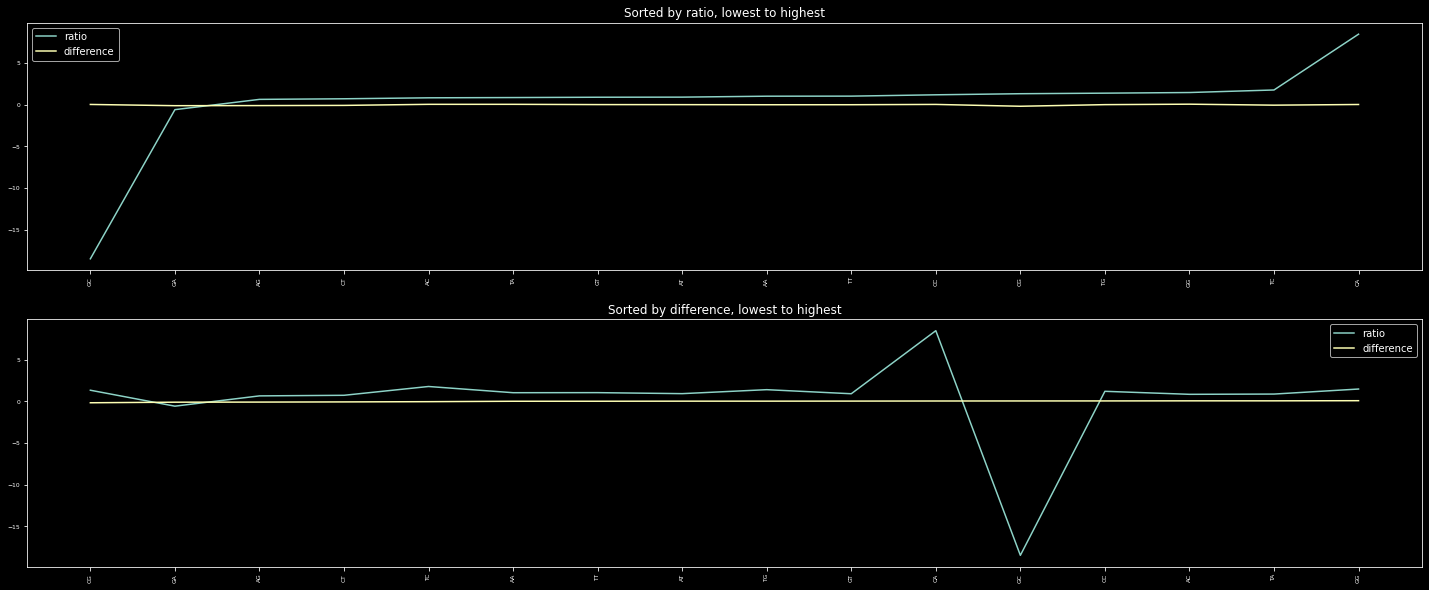

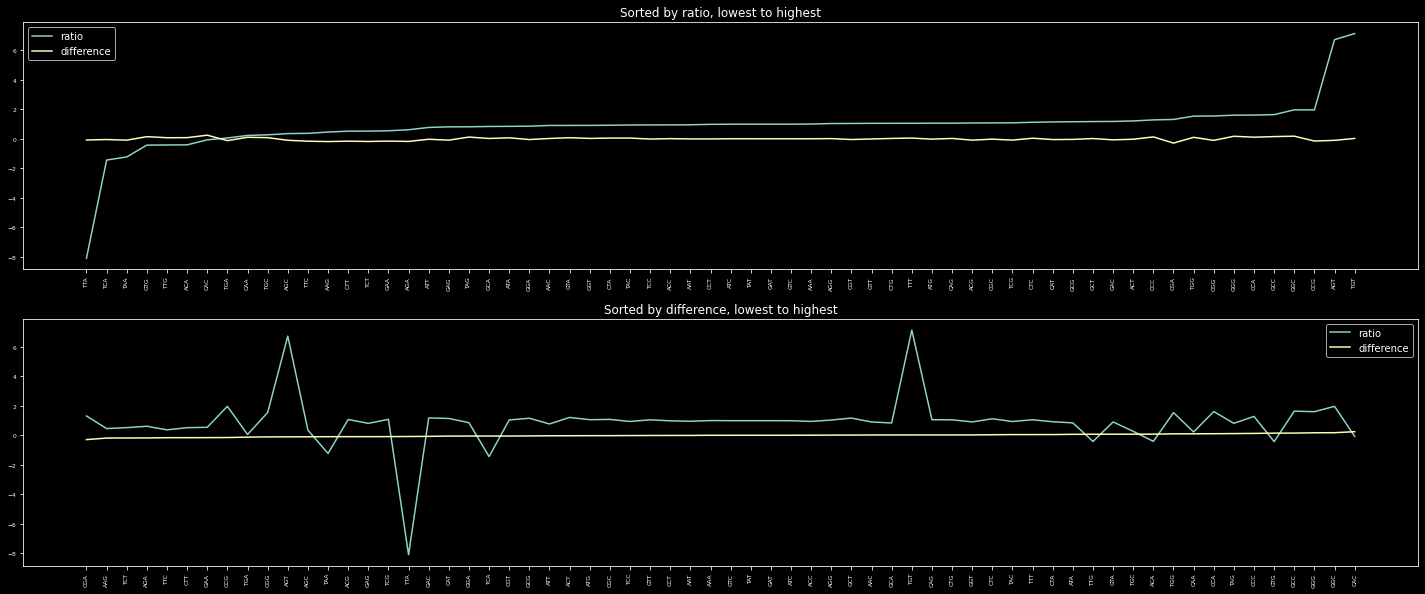

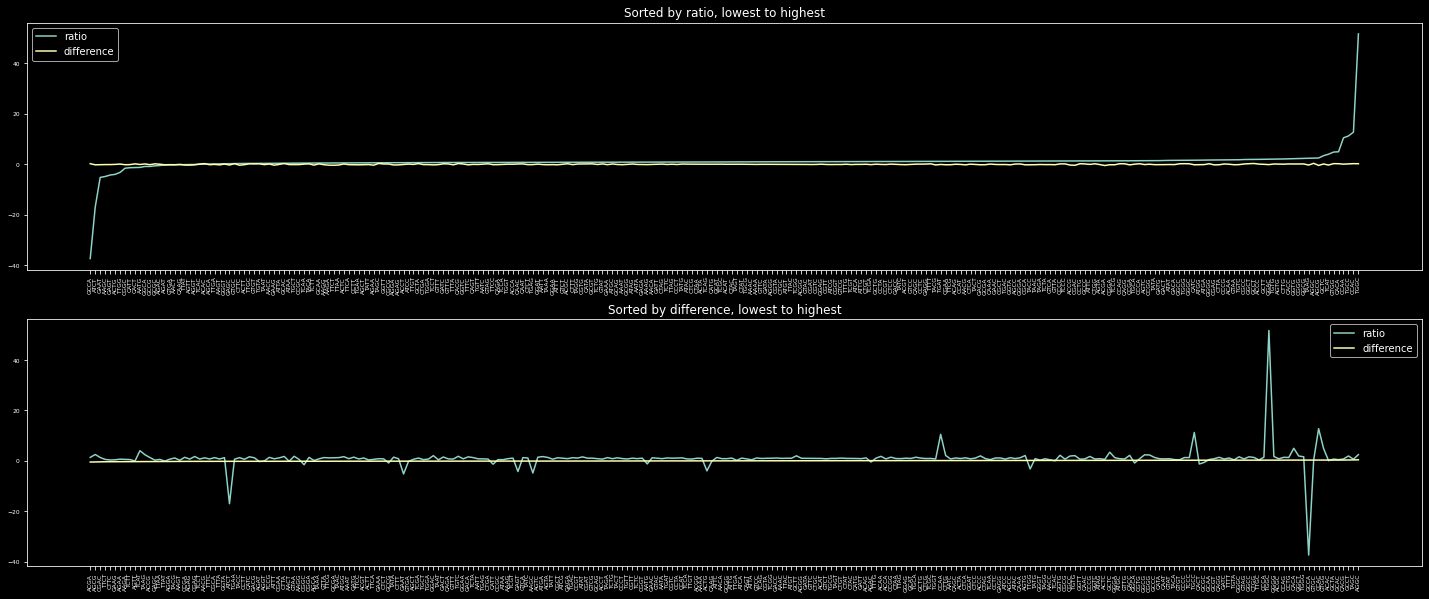

In [195]:
# Display results
display(results_df)

### (Optional) _(4 pts)_ Building machine learning models
K-mer frequencies can be used as (simple) features for training machine learning models to
distinguish sensitive and insensitive transcripts. To this end, a sequence is represented by a
feature vector of k-mer counts.


Write code to generate kmer frequency feature vectors for all transcripts.

(a) The first step is to divide the data set into a training set and a test set for external
validation. From the transcripts, randomly select a set containing 80% of the data:
400 sensitive and insensitive transcripts each. This set will form the training data. The
remaining 20% of the transcripts form the external validation set. (see Figure 1)

In [207]:
# Machine learning imports

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [279]:
# For a given k:

def kmer_dataframe(k:int=2) -> pd.DataFrame:
	"""For a given k, calculate log_odds_ratio and save it"""
	labels = []
	logs_odds = []

	# Open all files and get lists of sequences
	for file in [sensitive_file, insensitive_file]:
		with open(file) as f:
			label ,sequences  = zip(*fa.all_fasta_sequences(f))

			# Calculare freq
			for seq in sequences:
				observed = kmer_frequencies(seq,k)
				background = expected_relative_frequency(seq, observed)
				logs_odds.append(log_odds_ratio(observed, background))

			# Save info
			labels.extend([ lab.split(":")[0] for lab in  label])

	#Turn into dataframe
	kmers = [ "".join(kmer) for kmer in it.product(['A','G','T','C'], repeat=k) ]
	dataset = pd.DataFrame()
	dataset['label'] = labels
	for kmer in kmers:
		dataset[kmer] = [ result[kmer] for result in logs_odds ]
	return dataset


In [280]:
dataset = kmer_dataframe()

In [286]:
def split_data(dataset, test_size:float=0.20) -> tuple[list,list,list,list]:
	"""Splits dataset into two sets"""
	# Split into labels and features
	labels = dataset['label']
	features = dataset.drop(['label'],axis=1)

	# Create training (75%) and test (25%) sets
	features_train, features_test , labels_train , labels_test = train_test_split(features,labels,
																			  random_state=42, test_size =test_size)
	return features_train, features_test , labels_train , labels_test

In [ ]:
features_train, features_test , labels_train , labels_test= split_data(dataset)

(b) Using the training set, train Support Vector Machines with a linear kernel using grid
search for parameter C selecting C from ```[10**x for x in numpy.linspace(-2,2,9)]```,
i.e. ```[0.01,0.0316,0.1,0.316,1,3.16,10,31.6,100]``` for k = 2; 3; and 4. Use cross
validation with an appropriate number of n folds, e.g. n = 5. Which is the best C for
the different k's?


In [290]:
def grid_search(params, classifier,features_train, labels_train):
	"""Grid search to find best parameters"""
	# Set up the grid search
	gs = GridSearchCV(classifier,params,n_jobs=-1,cv=5,scoring='accuracy')

	# Fit gs to training data
	gs_results = gs.fit(features_train, labels_train)

	# Find best fit
	print(f'Best score: {gs_results.best_score_}')
	print(f'Best parameters: \n{gs_results.best_params_}')

	# Get score
	print(f'\nScore: {gs.score(features_test, labels_test)}')

	return gs


### SVM : Grid Search

In [295]:
# Create SVM Classifier
classifier_svm = SVC(kernel='linear')

# Parameter grid to search over using grid search
params={
	'C' :[10**x for x in np.linspace(-2,2,9)]
}

# Run grid search for k=[2,3,4]
for k in [2,3,4]:
	# Calculate dataset
	dataset = kmer_dataframe(k)
	# Split data
	features_train, features_test , labels_train , labels_test= split_data(dataset)
	# Grid Search
	print(f"\nK={k}")
	gs = grid_search(params, classifier_svm,features_train, labels_train)


K=2
Best score: 0.7575000000000001
Best parameters: 
{'C': 10.0}

Score: 0.715

K=3
Best score: 0.7587499999999999
Best parameters: 
{'C': 10.0}

Score: 0.75

K=4
Best score: 0.77125
Best parameters: 
{'C': 0.01}

Score: 0.75


(c) Determine accuracy, precision and recall for the test set for the best three classifiers
corresponding to k = 2; 3; and 4.

In [297]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def parameter_check(pred, labels_test):
    """Determines accuracy, precision, recall, f1 and aoc arc curve"""
    accuracy = accuracy_score(labels_test , pred)
    precision = precision_score(labels_test , pred, pos_label='sensitive')
    recall = recall_score(labels_test , pred, pos_label='sensitive')
    return { 'accuracy': accuracy, 'precision':precision, 'recall':recall }

In [298]:
for k in [2,3,4]:
	# Calculate dataset
	dataset = kmer_dataframe(k)
	# Split data
	features_train, features_test , labels_train , labels_test= split_data(dataset)
	# Grid Search
	print(f"\nK={k}")
	gs= grid_search(params, classifier_svm,features_train, labels_train)
	# Predict
	labels_preds = gs.predict(features_test)
	# Calculate results parameters
	best_par = parameter_check(labels_preds, labels_test)
	print(best_par)



K=2
Best score: 0.7575000000000001
Best parameters: 
{'C': 10.0}

Score: 0.715
{'accuracy': 0.715, 'precision': 0.7294117647058823, 'recall': 0.6458333333333334}

K=3
Best score: 0.7587499999999999
Best parameters: 
{'C': 10.0}

Score: 0.75
{'accuracy': 0.75, 'precision': 0.7395833333333334, 'recall': 0.7395833333333334}

K=4
Best score: 0.77125
Best parameters: 
{'C': 0.01}

Score: 0.75
{'accuracy': 0.75, 'precision': 0.7346938775510204, 'recall': 0.75}


(d) Repeat (b)-(c) for a Random Forest classifier. Here, you do not need to perform a
parameter search. Instead simply use the default parameters.

In [299]:
from sklearn.ensemble import RandomForestClassifier

# Run grid search for k=[2,3,4]
for k in [2,3,4]:
	# Calculate dataset
	dataset = kmer_dataframe(k)
	# Split data
	features_train, features_test , labels_train , labels_test= split_data(dataset)
	# Grid Search (empty dict for parameters, since we're using the defaults)
	print(f"\nK={k}")
	gs = grid_search({}, RandomForestClassifier(),features_train, labels_train) # Default params
	# Predict
	labels_preds = gs.predict(features_test)
	# Calculate results parameters
	best_par = parameter_check(labels_preds, labels_test)
	print(best_par)




K=2
Best score: 0.70625
Best parameters: 
{}

Score: 0.695
{'accuracy': 0.695, 'precision': 0.7058823529411765, 'recall': 0.625}

K=3
Best score: 0.72
Best parameters: 
{}

Score: 0.765
{'accuracy': 0.765, 'precision': 0.7692307692307693, 'recall': 0.7291666666666666}

K=4
Best score: 0.75125
Best parameters: 
{}

Score: 0.775
{'accuracy': 0.775, 'precision': 0.7741935483870968, 'recall': 0.75}


Best algorithm would be RandomForestClassifier, for k = 3